# Stock Price Classification
By: Jared Berry

In [1]:
# Quality of life
import os
import time
import warnings
from collections import defaultdict

# I/O and data structures
import pickle
import pandas as pd
import numpy as np

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

# Model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn import metrics

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Magic
%matplotlib inline
%load_ext pycodestyle_magic
sns.set_style('darkgrid')

In [3]:
warnings.filterwarnings('ignore')

## Set-up

#### Imports

In [4]:
# Import modeling helper functions
from modeling_funcs import *

In [5]:
# Import
inpath = "model_dictionary.pickle"
with open(inpath, 'rb') as f:
    modeling = pickle.load(f)

In [6]:
# Pull out the features dataframe
train = modeling['features']

#### Feature selection

In [7]:
# Set a feature selection list (THINK ABOUT INFORMING THIS SELECTION WITH SHRINKAGE METHODS, I.E. LASSO REGRESSION)
features = ['High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose', 'Year',
            'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Pct_Change_Daily',
            'Pct_Change_Monthly', 'Pct_Change_Yearly', 'RSI', 'Volatility',
            'Yearly_Return_Rank', 'Monthly_Return_Rank', 'Pct_Change_Class',
            'Rolling_Yearly_Mean_Positive_Days', 'Rolling_Monthly_Mean_Positive_Days', 
            'Rolling_Monthly_Mean_Price', 'Rolling_Yearly_Mean_Price',
            'Momentum_Quality_Monthly', 'Momentum_Quality_Yearly', 'SPY_Trailing_Month_Return',
            'open_l1', 'open_l5', 'open_l10', 'close_l1', 'close_l5', 'close_l10',
            'return_prev1_open_raw', 'return_prev5_open_raw', 'return_prev10_open_raw',
            'return_prev1_close_raw', 'return_prev5_close_raw', 'return_prev10_close_raw',
            'pe_ratio', 'debt_ratio', 'debt_to_equity', 'roa',
            'beta']

In [8]:
# Select on features to pass to modeling machinery, along with necessary indexers
X = train[features]
tickers = train['ticker'].unique().tolist()

In [9]:
# Choose a ticker
target = modeling['target_21_rel_return']

## Modeling

#### Panel-level

Given that there are bound to be a number of systemic considerations that impact the price of a stock at any given point in time, it is prudent to perform and evaluate predictions across the panel of S&P 500 stocks in our sample, which will capture potential linkages between different stocks, and allow us to explore the possibility of using features generated from clustering to group like stocks in the panel.

In [ ]:
# Create a panel-level copy
y_p = target.copy()

# Indexes of hold-out test data (the 21 days of data preceding the present day)
test_idx = np.where(np.isnan(y_p))[0].tolist()

# In order to ensure grouping is done properly, remove this data from a ticker-identification set as well
ticker_locs = train[['ticker','date_of_transaction']].drop(train.index[test_idx]).reset_index().drop('index', axis=1)

In [ ]:
# Create a panel-level copy; normalize by day
X_p = X.copy(deep=True)
X_p = X_p.groupby(['Year', 'Month', 'Day']).apply(lambda x: (x - np.mean(x))/np.std(x)).fillna(0)

In [ ]:
# Remove hold-out test data
y_p = np.delete(y_p, test_idx)
X_p_holdout = X_p.loc[X_p.index[test_idx]]
X_p = X_p.drop(X_p.index[test_idx])

In [ ]:
# Exponential Moving Average smoothing (skip if not)
y_p_smoothed = np.zeros(y_p.shape[0])
for t in tickers:
    idx = ticker_locs.loc[ticker_locs['ticker'] == t].index.tolist()
    y_to_smooth = y_p[idx]
    
    # Compute EMA smoothing of target within ticker
    EMA = 0
    gamma_ = 1
    for ti in range(len(y_to_smooth)):
        EMA = gamma_*y_to_smooth[ti] + (1-gamma_)*EMA
        y_to_smooth[ti] = EMA
        
    y_p_smoothed[idx] = y_to_smooth

In [ ]:
y_p_smoothed = y_p.copy()

In [ ]:
# LGBM
model_dict = fit_lgbm_classifier(X_p, 
                                 y_p_smoothed, 
                                 X_p_holdout, 
                                 ticker="", 
                                 ema_gamma=1, 
                                 n_splits=12,
                                 cv_method='ts',
                                 groups=ticker_locs, 
                                 labeled=False,
                                 label="LGBM Classifier",
                                 param_search=None,
                                 holdout_method='distributed',
                                 threshold_search=False,
                                 export=True)

In [ ]:
# Logistic regression
model_dict = fit_sklearn_classifier(X_p, 
                                    y_p, 
                                    X_p_holdout, 
                                    ticker="", 
                                    ema_gamma=1, 
                                    n_splits=12,
                                    cv_method='ts',
                                    model=LogisticRegression,
                                    label='Logit', 
                                    param_search=None,
                                    holdout_method='distributed',
                                    threshold_search=False,
                                    n_jobs=-1,
                                    export=True)

In [ ]:
# kNN
model_dict = fit_sklearn_classifier(X_p, 
                                    y_p, 
                                    X_p_holdout, 
                                    ticker="", 
                                    ema_gamma=1, 
                                    n_splits=12,
                                    cv_method='ts',
                                    model=KNeighborsClassifier,
                                    label='kNN Classifier', 
                                    param_search=None,
                                    holdout_method='distributed',
                                    threshold_search=False,
                                    n_jobs=-1,
                                    export=True)

In [ ]:
# RandomForest
model_dict = fit_sklearn_classifier(X_p, 
                                    y_p, 
                                    X_p_holdout, 
                                    ticker="", 
                                    ema_gamma=1, 
                                    n_splits=12,
                                    cv_method='ts',
                                    model=RandomForestClassifier,
                                    label='RandomForest Classifier', 
                                    param_search=None,
                                    holdout_method='distributed',
                                    threshold_search=False,
                                    n_jobs=-1,
                                    export=True)

In [ ]:
# GBC
model_dict = fit_sklearn_classifier(X_p, 
                                    y_p, 
                                    X_p_holdout, 
                                    ticker="", 
                                    ema_gamma=1, 
                                    n_splits=12,
                                    cv_method='ts',
                                    model=GradientBoostingClassifier,
                                    label='Boosting Classifier', 
                                    param_search=None,
                                    holdout_method='distributed',
                                    threshold_search=False,
                                    export=True)

In [ ]:
test = model_dict['preds_df']
test = test[test['split_number'] != 0]
print(metrics.confusion_matrix(test['expected'], test['predicted']))
print(metrics.roc_auc_score(test['expected'], test['predicted']))
print(metrics.classification_report(test['expected'], test['predicted']))

#### Ticker-level 

At the heart of this analysis is a time-series prediction problem. As such, it is prudent to explore running models for each individual stock. We can envision averaging the results of both modeling approaches to incorporate the contribution of both into a final prediction.

In [ ]:
results_dfs = []
for i, t in enumerate(tickers[:50]):
    
    # Pull only feature/target data for the relevant stocker
    X_t = X.loc[train['ticker'] == t,:]
    y_t = np.array(target)[train['ticker'] == t]
    
    # Indexes of hold-out test data (the 21 days of data preceding the present day)
    test_idx = np.where(np.isnan(y_t))[0].tolist()
    
    # Simple feature-scaling - for now, replace missings with 0 (i.e. the mean of a normalized feature)
    X_t = X_t.apply(lambda x: (x - np.mean(x))/np.std(x)).fillna(0)
    
    # Remove hold-out test data
    y_t = np.delete(y_t, test_idx)
    X_t_holdout = X_t.loc[X_t.index[test_idx]]
    X_t = X_t.drop(X_t.index[test_idx])
    
    # Fit and evaluate
    model_dict = fit_lgbm_classifier(X_t, 
                                     y_t,
                                     X_t_holdout, 
                                     ticker=t, 
                                     ema_gamma=1, 
                                     n_splits=12,
                                     cv_method='tswindow', 
                                     labeled=False,
                                     param_search=None,
                                     holdout_method='distributed',
                                     threshold_search=True,
                                     export=False)

    results_dfs.append(model_dict)

In [ ]:
# Set parameters
cv_method_ = 'tswindow'
label_ = 'RF Classifier'
model_ = RandomForestClassifier

results_dfs = []
for i, t in enumerate(tickers[:1]):
    
    # Pull only feature/target data for the relevant stocker
    X_t = X.loc[train['ticker'] == t,:]
    y_t = np.array(target)[train['ticker'] == t]
    
    # Indexes of hold-out test data (the 21 days of data preceding the present day)
    test_idx = np.where(np.isnan(y_t))[0].tolist()
    
    # Simple feature-scaling - for now, replace missings with 0 (i.e. the mean of a normalized feature)
    X_t = X_t.apply(lambda x: (x - np.mean(x))/np.std(x)).fillna(0)
    
    # Remove hold-out test data
    y_t = np.delete(y_t, test_idx)
    X_t_holdout = X_t.loc[X_t.index[test_idx]]
    X_t = X_t.drop(X_t.index[test_idx])
    
    # Fit and evaluate
    model_dict = fit_sklearn_classifier(X_t, 
                                        y_t, 
                                        X_t_holdout, 
                                        ticker=t, 
                                        ema_gamma=1, 
                                        n_splits=12,
                                        cv_method=cv_method_,
                                        model=model_,
                                        label=label_, 
                                        param_search=None,
                                        holdout_method='full',
                                        threshold_search=True,
                                        n_estimators=100,
                                        export=False)
    
    results_dfs.append(model_dict)

In [ ]:
# Export ticker-level models
model_outpath = "{}_{}_{}.pickle".format(slugify(label_), ticker="all_tickers", cv_method_)
with open(model_outpath, 'wb') as f:
    pickle.dump(results_dfs, f)

## Evaluation

#### Panel-level

In [10]:
# Set path to pickle file containing panel-level model
model_inpath = "lgbm_classifier_panel_ts.pickle"

In [14]:
# Import
with open(model_inpath, 'rb') as f:
    results_df = pickle.load(f)

In [21]:
ticker_performance = results_df['preds_df']
feature_importances = pd.DataFrame(results_df['feature_importances'], columns=['feature', 'importance'])

#### Ticker-level

In [ ]:
# Stand up results dataframes
performance_dfs = []
feature_importance_dfs = []
holdout_predictions = defaultdict(list)

for r in results_dfs:
    performance_dfs.append(r['preds_df'])
    feature_importance_dfs.append(pd.DataFrame(r['feature_importances'], columns=['feature', 'importance']))
    holdout_predictions[r['preds_df'].ticker.unique().tolist()[0]] = r['holdout_probs']
    
ticker_performance = pd.concat(performance_dfs, axis=0)
feature_importances = pd.concat(feature_importance_dfs, axis=0)

### Visualization

In [17]:
# Remove unpopulated splits (training data never used for validation)
ticker_performance = ticker_performance[ticker_performance['split_number'] != 0]

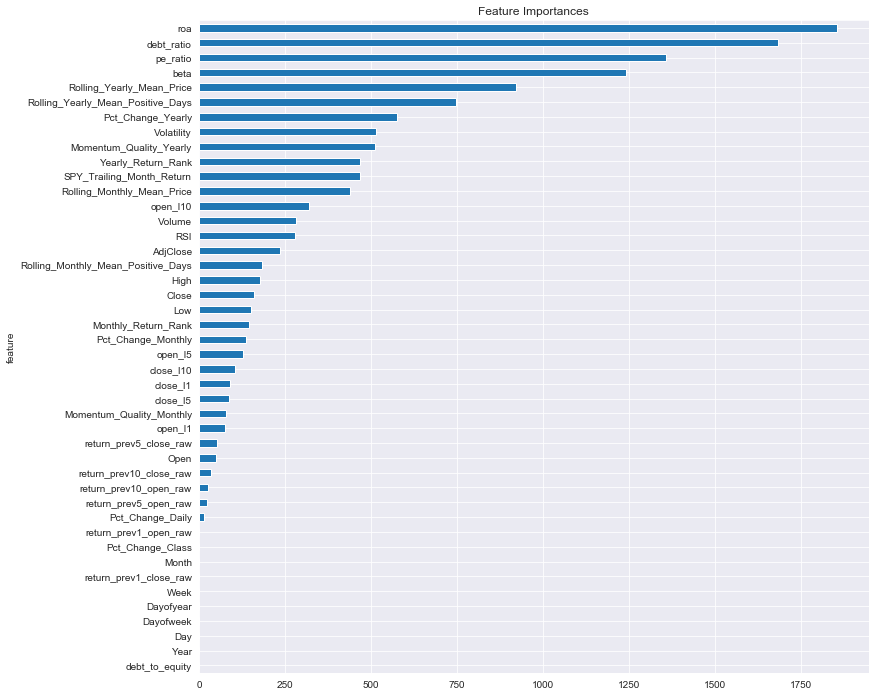

In [22]:
# Average feature importances across all ticker-level models
average_importances = feature_importances.groupby('feature').mean().sort_values('importance')
average_importances.plot(kind='barh', title="Feature Importances", legend=False, figsize=(12,12))
plt.show()

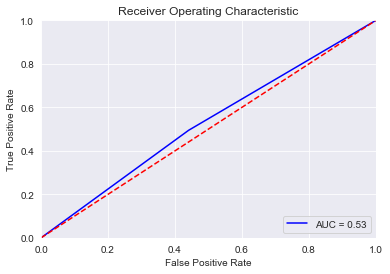

In [23]:
# AUC Curve
fpr, tpr, threshold = metrics.roc_curve(ticker_performance['expected'], ticker_performance['predicted'])
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Precision-Recall Curves


In [ ]:
# Classification Report
